Se dau mai multe imagini (in folderul lab04\images) care pot contine biciclete. Se doreste sa se identifice care dintre imagini contin bicilete si unde se situeaza ele in aceste imagini.

📝 Cerinte
Specificaţi, implementaţi și testați subalgoritmi pentru problema enuntata.

1. Sa se foloseasca un algoritm de clasificare a imaginilor (etapa de inferenta/testare) si sa se stabileasca performanta acestui algoritm de clasificare binara (imagini cu biciclete vs. imagini fara biciclete).

2. Pentru imaginile care contin biciclete:

a. sa se localizeze automat bicicletele in aceste imagini si sa se evidentieze chenarele care incadreaza bicicletele

b. sa se eticheteze (fara ajutorul algoritmilor de AI) aceste imagini cu chenare care sa incadreze cat mai exact bicicletele. Care task dureaza mai mult (cel de la punctul a sau cel de la punctul b)?

c. sa se determine performanta algoritmului de la punctul a avand in vedere etichetarile realizate la punctul b (se vor folosi cel putin 2 metrici).

1. Sa se foloseasca un algoritm de clasificare a imaginilor (etapa de inferenta/testare) si sa se stabileasca performanta acestui algoritm de clasificare binara (imagini cu biciclete vs. imagini fara biciclete).

In [53]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
import os
import glob
from PIL import Image
import numpy as np

subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

image_paths = glob.glob("images/*.jpg")

results = {}
bikes = []

for img_path in image_paths:
    with open(img_path, "rb") as img:
        result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.tags])

    contains_bicycle = any(tag.name.lower() == "bicycle" for tag in result.tags)

    prediction = 1 if contains_bicycle else 0
    truth = 1 if "bike" in os.path.basename(img_path) else 0

    results[os.path.basename(img_path)] = {"prediction": prediction , "truth": truth}

    if prediction == 1:
        bikes.append(img_path)

TP = TN = FP = FN = 0

for res in results.values():
    pred = res["prediction"]
    actual = res["truth"]

    if pred == 1 and actual == 1:
        TP += 1
    elif pred == 0 and actual == 0:
        TN += 1
    elif pred == 1 and actual == 0:
        FP += 1
    elif pred == 0 and actual == 1:
        FN += 1

accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0


print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# for img_name, res in results.items():
#     prediction = res["prediction"]
#
#     if prediction == 1:
#         prediction_str = "Bicicletă detectată"
#     else:
#         prediction_str = "Fără bicicletă"
#
#     print(f"Imaginea: {img_name}")
#     print(f"Predicție: {prediction_str}")
#     print("-" * 50)


True Positives (TP): 10
True Negatives (TN): 10
False Positives (FP): 0
False Negatives (FN): 0
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


Pentru imaginile care contin biciclete:

a. sa se localizeze automat bicicletele in aceste imagini si sa se evidentieze chenarele care incadreaza bicicletele

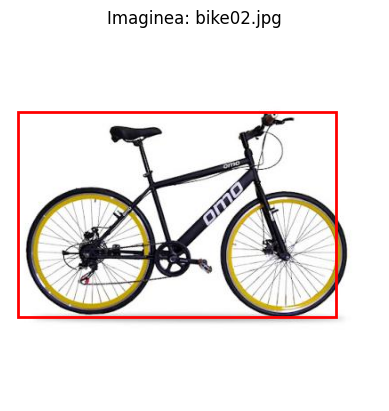

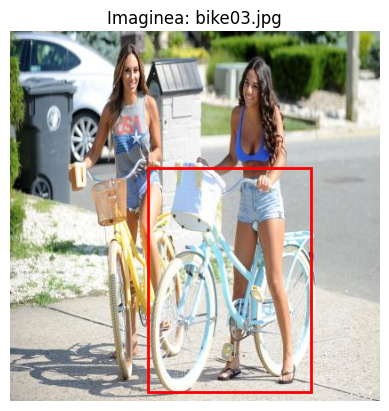

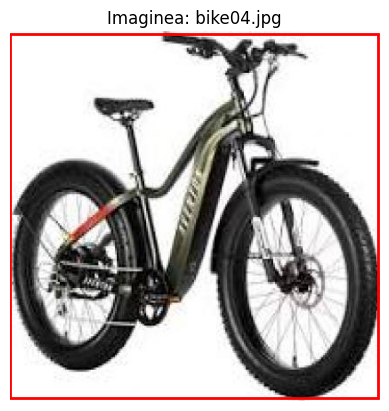

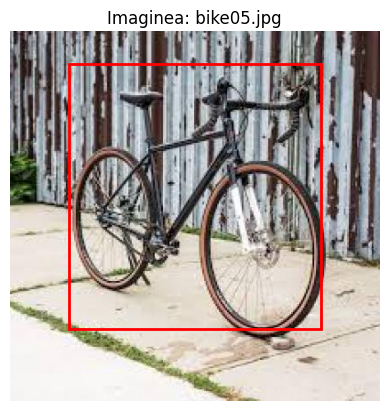

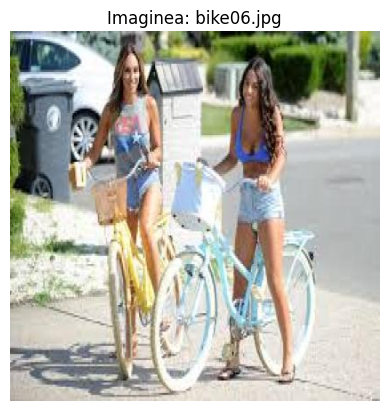

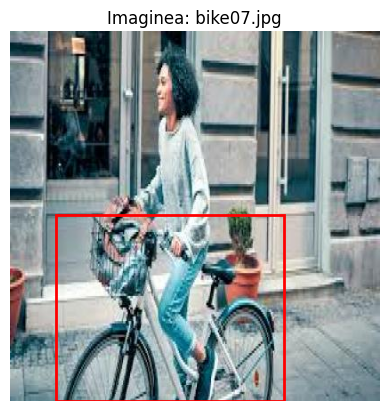

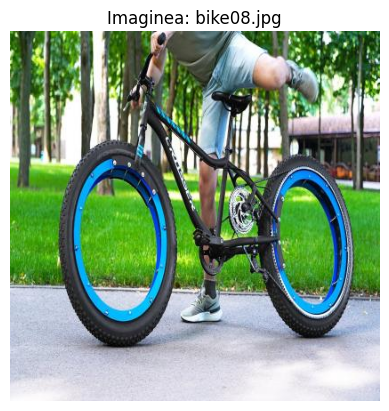

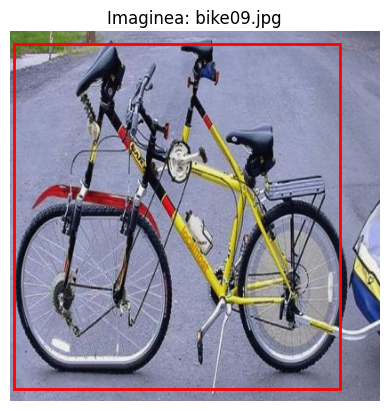

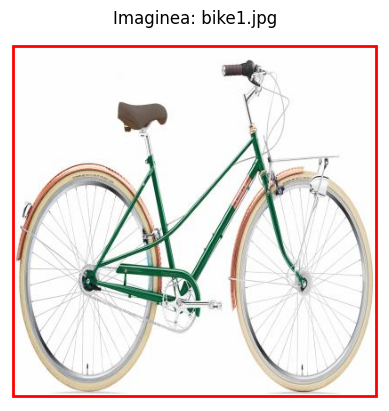

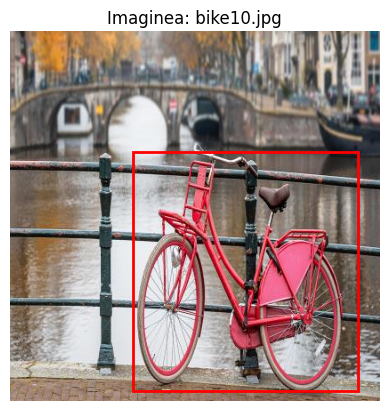

In [77]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

results = {}
for img_path in bikes:
    with open(img_path, "rb") as img:
        result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])

    im = Image.open(img_path).convert("RGB")
    im = np.array(im)

    fig, ax = plt.subplots()
    ax.imshow(im)
    ax.axis("off")


    for ob in result.objects:
        if ob.object_property.lower() == "bicycle":
            detected_boxes = []
            x = ob.rectangle.x
            y = ob.rectangle.y
            width = ob.rectangle.w
            height = ob.rectangle.h

            detected_boxes.append((x, y, width, height))
            results[os.path.basename(img_path)] = {"detected_boxes": detected_boxes, "true_boxes": []}

            rect = Rectangle((x, y), width, height, linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)

    plt.title(f"Imaginea: {os.path.basename(img_path)}")
    plt.show()



b. sa se eticheteze (fara ajutorul algoritmilor de AI) aceste imagini cu chenare care sa incadreze cat mai exact bicicletele. Care task dureaza mai mult (cel de la punctul a sau cel de la punctul b)?

- am desenat manual chenarele in https://annotate.officialstatistics.org/ si am salvat fiecare imagine cu chenarul desenat intr-un fisier de tip .json (a durat aprox 15 minute, cu siguranta mai mult decat varianta cu ai).

c. sa se determine performanta algoritmului de la punctul a avand in vedere etichetarile realizate la punctul b (se vor folosi cel putin 2 metrici).

In [83]:
import json

json_paths = glob.glob("images_json/*.json")

for json_path in json_paths:
    with open(json_path, 'r') as f:
        data = json.load(f)


    img_filename = os.path.splitext(os.path.basename(json_path))[0] + '.jpg'

    img_metadata = data["_via_img_metadata"].get(img_filename)
    if not img_metadata:
        print(f"Nu există metadate pentru {img_filename}")
        continue

    true_boxes = [
        (region["shape_attributes"]["x"], region["shape_attributes"]["y"],
         region["shape_attributes"]["width"], region["shape_attributes"]["height"])
        for region in img_metadata["regions"]
    ]
    img_filename = img_filename.lower()
    if img_filename in results:
        results[img_filename]["true_boxes"] = true_boxes
    else:
        results[img_filename] = {"true_boxes": true_boxes}


def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calcularea coordonatelor de intersecție
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    # Dacă nu există intersecție, returnează IoU = 0
    if xi1 >= xi2 or yi1 >= yi2:
        return 0.0

    # Aria intersecției
    inter_area = (xi2 - xi1) * (yi2 - yi1)

    # Aria totală (uniunea)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    # IoU
    return inter_area / union_area



TP = 0
FP = 0
FN = 0


for img_filename, res in results.items():
    true_boxes = res.get("true_boxes", [])
    detected_boxes = res.get("detected_boxes", [])

    err = 0
    count = 0
    for true_box, detected_box in zip(true_boxes, detected_boxes):
        for t, d in zip(true_box, detected_box):  # Compară element cu element
            err += (t - d) ** 2
            count += 1

    err /= count if count > 0 else 1

    print("Detection error in ", img_filename, ": ", err)



    for detected_box in detected_boxes:
        x1, y1, w1, h1 = detected_box

        matched = False
        for true_box in true_boxes:
            x2, y2, w2, h2 = true_box
            iou = calculate_iou((x1, y1, w1, h1), (x2, y2, w2, h2))

            if iou >= 0.5:
                matched = True
                break

        if matched:
            TP += 1
        else:
            FP += 1

    for true_box in true_boxes:
        matched = False
        x2, y2, w2, h2 = true_box
        for detected_box in detected_boxes:
            x1, y1, w1, h1 = detected_box
            iou = calculate_iou((x1, y1, w1, h1), (x2, y2, w2, h2))
            if iou >= 0.5:
                matched = True
                break
        if not matched:
            FN += 1


precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")




Detection error in  bike02.jpg :  51.75
Detection error in  bike03.jpg :  86.75
Detection error in  bike04.jpg :  41.0
Detection error in  bike05.jpg :  52.75
Detection error in  bike07.jpg :  226.25
Detection error in  bike09.jpg :  111.75
Detection error in  bike1.jpg :  66.5
Detection error in  bike10.jpg :  181.5
Detection error in  bike06.jpg :  0.0
Detection error in  bike08.jpg :  0.0
True Positives (TP): 8
False Positives (FP): 0
False Negatives (FN): 4
Precision: 1.00
Recall: 0.67


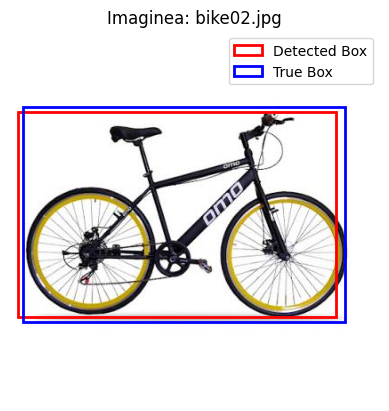

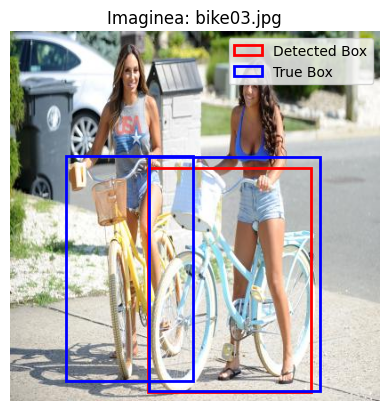

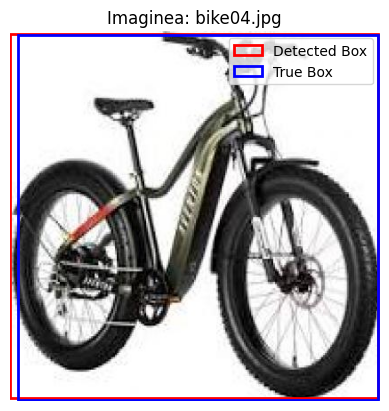

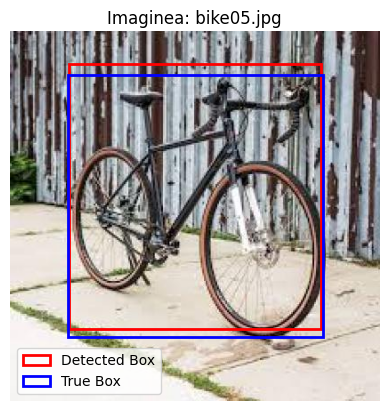

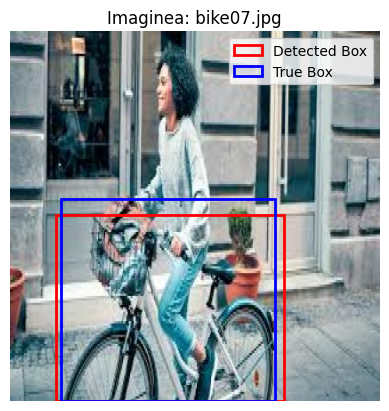

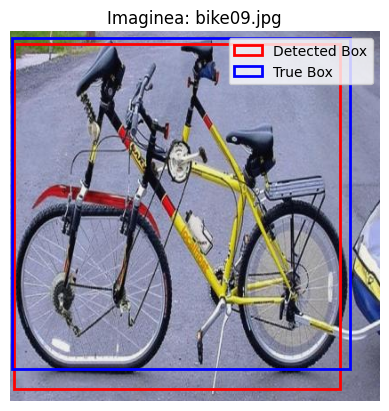

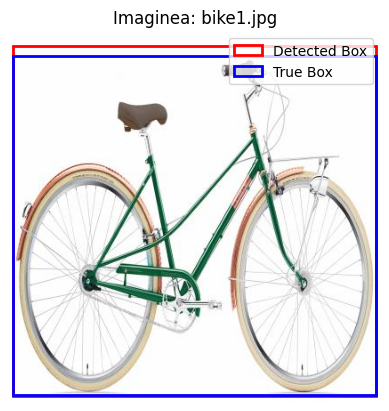

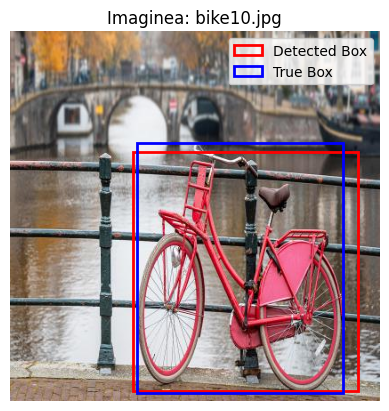

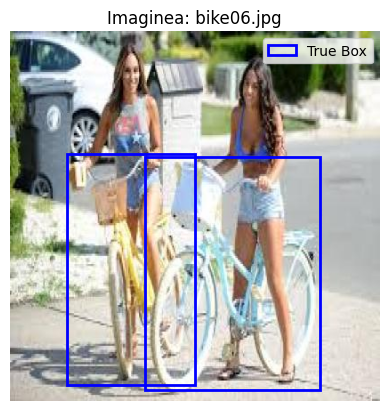

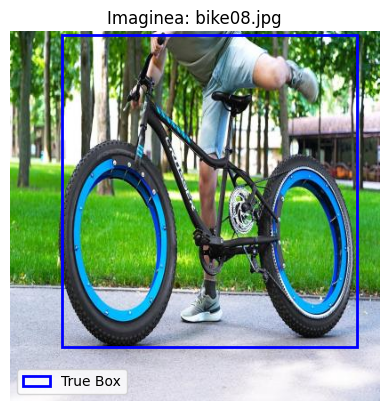

In [84]:
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Rectangle

for img_filename, res in results.items():
    img_path = os.path.join("images", img_filename)

    im = plt.imread(img_path)

    fig, ax = plt.subplots()
    ax.imshow(im)
    ax.axis("off")

    if "detected_boxes" in res:
        for box in res["detected_boxes"]:
            x, y, width, height = box
            ax.add_patch(
                Rectangle(
                    xy=(x, y),
                    width=width,
                    height=height,
                    fill=False,
                    edgecolor="red",
                    linewidth=2,
                    label="Detected Box" if "Detected Box" not in [l.get_label() for l in ax.patches] else ""
                )
            )

    if "true_boxes" in res:
        for box in res["true_boxes"]:
            x, y, width, height = box
            ax.add_patch(
                Rectangle(
                    xy=(x, y),
                    width=width,
                    height=height,
                    fill=False,
                    edgecolor="blue",
                    linewidth=2,
                    label="True Box" if "True Box" not in [l.get_label() for l in ax.patches] else ""
                )
            )


    if ax.patches:
        ax.legend()

    plt.title(f"Imaginea: {img_filename}")
    plt.show()

#ok
